In [1]:
from netCDF4 import MFDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Look at the first ten days of output of a FVCOMICM v4 run

In [2]:
ds = MFDataset("/net/babaracus/home/benr/wqmodels/ssm/unionriver/wqm/1x/outputs/ssm_FVCOMICM_0000*.nc")
ds

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: 
    institution: DOE/PNNL/MSL/BSRC
    source: FVCOM-ICM 3.0
    history: model started at: 20/10/2022   10:50
    Conventions: CF-1.0
    dimensions = ('scalar', 'node', 'nele', 'siglay', 'siglev', 'three', 'four', 'nine', 'time')
    variables = ('nprocs', 'partition', 'Initial_Density', 'x', 'y', 'siglay', 'siglev', 'h', 'nv', 'time', 'iint', 'zeta', 'salinity', 'temp', 'depth', 'CCHL1', 'DOXG', 'LDOC', 'RDOC', 'LPOC', 'RPOC', 'B1', 'B2', 'NH4', 'NO3', 'LDON', 'RDON', 'LPON', 'RPON', 'PO4', 'TDIC', 'TALK', 'pH', 'pCO2', 'IAVG')
    groups = ()

Light is in the IAVG variable

In [3]:
ds['IAVG']

<class 'netCDF4._netCDF4._Variable'>
float32 IAVG('time', 'siglay', 'node')
    long_name: IAVG
    standard_name: IAVG
    units: Einstein meters-2 day-1
    grid: fvcom_grid
    type: data
unlimited dimensions = ('time',)
current size = (216, 10, 16012)

Get the number of output times per day so we can construct a one-day moving average and avoid issues at night

In [4]:
times_per_day = int(86400 / (ds['time'][1] - ds['time'][0]))
times_per_day

4

Compute the moving average over `times_per_day` times, except at the beginning where a ramp-up is used

In [5]:
cs = ds['IAVG'][:].cumsum(axis=0, dtype=float)
cs[times_per_day:] -= cs[:-times_per_day]
avglight = np.zeros_like(cs)
for n in range(1, times_per_day):
    avglight[n-1,:] = cs[n - 1,:] / n
avglight[times_per_day - 1:,:] = cs[times_per_day - 1:,:] / times_per_day
avglight.shape

(216, 10, 16012)

Plot the surface light for a single node to ensure the smoothing worked

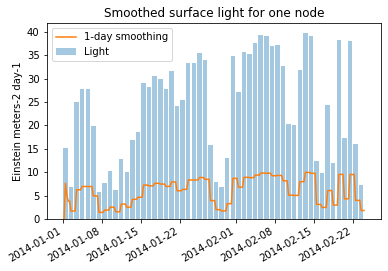

In [6]:
times = pd.Timestamp('2014-01-01') + pd.to_timedelta(ds['time'][:], 's')
fig, ax = plt.subplots()
ax.bar(times, ds['IAVG'][:,0,1200], alpha=0.4, label='Light')
ax.plot(times, avglight[:,0,1200], color='tab:orange', label='1-day smoothing')
ax.set(ylabel=ds['IAVG'].units, title="Smoothed surface light for one node")
ax.legend()
fig.autofmt_xdate()

Now construct a mask for all the locations/depths/times that fall below the photic zone (1% of surface light)

The == 0 case is needed to deal with the possibility that there is no light at the surface

In [7]:
mask = (avglight[:] == 0) | (avglight[:,:,:] < avglight[:,[0],:] * 0.01)
display(mask.shape)
with np.printoptions(threshold=np.inf):
    display(mask[:5,:,12000])

(216, 10, 16012)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True]])

To extract a state variable within the photic zone, construct a masked array of that variable with the above mask

In [8]:
photic_nitrate = np.ma.masked_array(ds['NO3'][:], mask=mask)
with np.printoptions(precision=4, threshold=np.inf):
    display(photic_nitrate[:5,:,12000])

masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --],
        [0.4176468253135681, 0.417702317237854, 0.41775181889533997,
         0.4177953898906708, 0.4178256094455719, 0.4178629517555237,
         0.4178995192050934, --, --, --],
        [0.40104198455810547, 0.4011945426464081, 0.40181076526641846,
         0.401801198720932, 0.4017876386642456, 0.40175938606262207,
         0.40172237157821655, --, --, --],
        [0.4075223505496979, 0.4075224697589874, 0.4075225591659546,
         0.40752261877059937, 0.40752264857292175, 0.40752270817756653,
         0.40752267837524414, --, --, --],
        [0.4006417691707611, 0.40064549446105957, 0.40067049860954285,
         0.40116965770721436, 0.402749240398407, 0.4035615026950836,
         0.4036708474159241, --, --, --]],
  mask=[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [False, False, False, False, False, False, False,  True,  True,
          True],
        [False, False, False

Now we can take the depth-wise mean of just the photic zone

In [9]:
mean_photic_nitrate = photic_nitrate.mean(axis=1)
display(mean_photic_nitrate.shape)
mean_photic_nitrate[:20,12000]

(216, 16012)

masked_array(data=[--, 0.4177834987640381, 0.40158826964242117,
                   0.4075225761958531, 0.40187273706708637,
                   0.4036533534526825, 0.4018847346305847,
                   0.405440092086792, 0.4041411280632019,
                   0.4061475098133087, 0.402864545583725,
                   0.40089303255081177, 0.4049007296562195,
                   0.40708855220249723, 0.4027836322784424,
                   0.40063568523951937, 0.4059579372406006,
                   0.40804338455200195, 0.4066291196005685,
                   0.40486458369663786],
             mask=[ True, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)